In [1]:
# imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.segmentation import MeanIoU
from torchvision.models import vgg19
import torchvision.transforms as transforms
from tqdm import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


# Question 1

## Data Visualization

In [2]:
label_map = {
    0: "Unlabeled",
    1: "Building",
    2: "Fence",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "Roadline",
    7: "Road",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Car",
    11: "Wall",
    12: "Traffic sign"
}

In [3]:
def visualize_segmentation(image_path, label_path):
    label_image = plt.imread(label_path)
    label_image = (label_image * 255).astype(np.uint8)
    fig, axes = plt.subplots(2, 7, figsize=(15, 6))
    axes = axes.flatten()

    image = plt.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    for i in range(13):
        binary_mask = (label_image[:, :, 0] == i).astype(np.uint8) * 255
        axes[i + 1].imshow(binary_mask, cmap='gray')
        axes[i + 1].set_title(f"Mask: {label_map[i]}")
        axes[i + 1].axis('off')

    for j in range(14, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

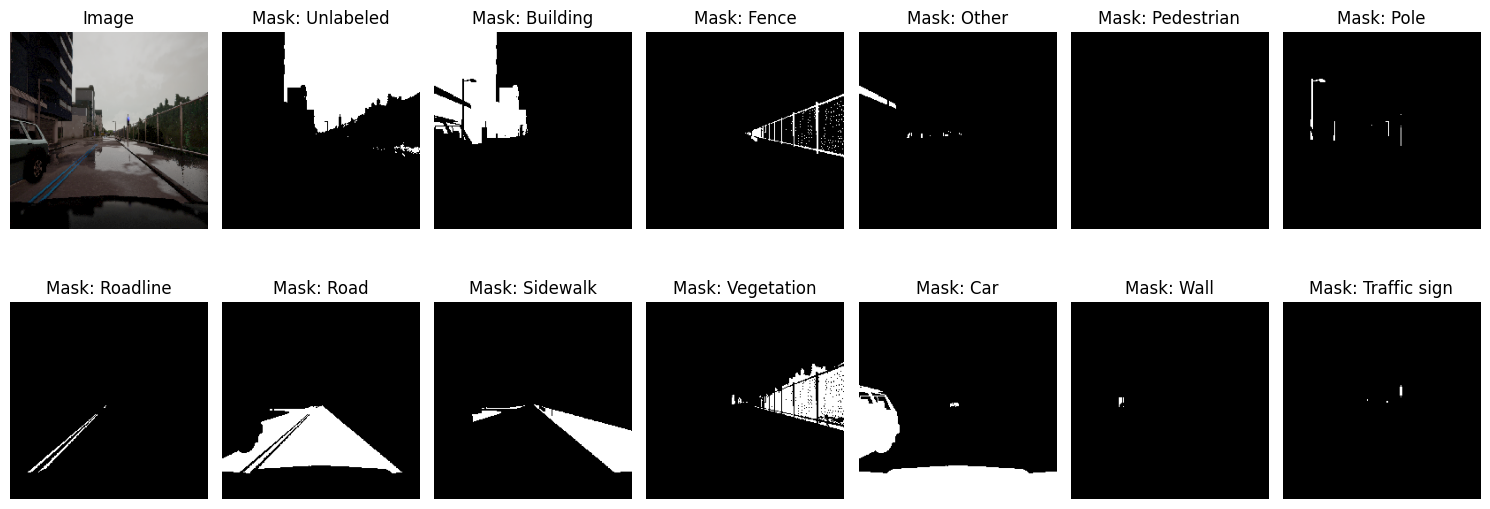

In [4]:
image_id = "02_00_009.png"
image_path = "./dataset/test/images/" + image_id
label_path = "./dataset/test/labels/" + image_id
visualize_segmentation(image_path, label_path)

## Data Loader

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.0
        image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        
        label = cv2.imread(label)
        label = label[:, :, 2]
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [6]:
train_images_dir = "./dataset/train/images/"
train_labels_dir = "./dataset/train/labels/"
train_image_files = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir)])
train_label_files = sorted([os.path.join(train_labels_dir, f) for f in os.listdir(train_labels_dir)])

In [7]:

train_images, val_images, train_labels, val_labels = train_test_split(
    train_image_files, train_label_files, test_size=0.2, random_state=42
)

In [8]:
test_images_dir = "./dataset/test/images/"
test_labels_dir = "./dataset/test/labels/"
test_images = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir)])
test_labels = sorted([os.path.join(test_labels_dir, f) for f in os.listdir(test_labels_dir)])

In [9]:
train_loader = DataLoader(
    SegmentationDataset(train_images, train_labels),
    batch_size=20,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    SegmentationDataset(val_images, val_labels),
    batch_size=20,
    shuffle=False,
    num_workers=4
)
test_loader = DataLoader(
    SegmentationDataset(test_images, test_labels),
    batch_size=20,
    shuffle=False,
    num_workers=4
)

[ 0  1  2  3  5  6  7  8  9 10]


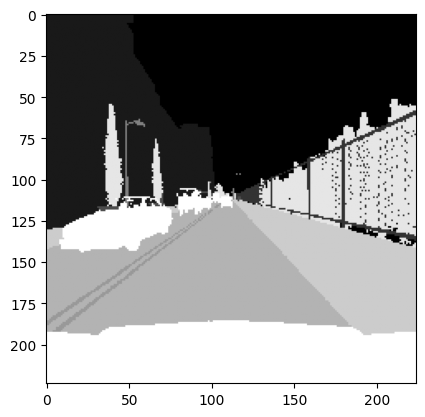

In [10]:
x = next(iter(test_loader))
print(np.unique(x[1][12]))
plt.imshow(x[1][12], cmap="gray")

## Model

In [11]:
class FCN(nn.Module):
    def __init__(self, num_classes, version, freeze):
        super(FCN, self).__init__()
        
        self.num_classes = num_classes
        self.version = version
        
        self.backbone = vgg19(weights="IMAGENET1K_V1")
        backbone_layers = self.backbone.features
        
        if freeze:
            for param in backbone_layers.parameters():
                param.requires_grad = False
        
        self.pools = nn.ModuleList()
        self.pools.append(nn.Sequential(*backbone_layers[:5]))
        self.pools.append(nn.Sequential(*backbone_layers[5:10]))
        self.pools.append(nn.Sequential(*backbone_layers[10:19]))
        self.pools.append(nn.Sequential(*backbone_layers[19:28]))
        self.pools.append(nn.Sequential(*backbone_layers[28:]))
        
        self.score_pools = nn.ModuleList()
        self.score_pools.append(nn.Conv2d(256, self.num_classes, kernel_size=(1, 1)))
        self.score_pools.append(nn.Conv2d(512, self.num_classes, kernel_size=(1, 1)))
        self.score_pools.append(nn.Conv2d(512, self.num_classes, kernel_size=(1, 1)))
        
        self.upsamples = nn.ModuleList()
        self.upsamples.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True))
        self.upsamples.append(nn.Upsample(scale_factor=8, mode="bilinear", align_corners=True))
        self.upsamples.append(nn.Upsample(scale_factor=16, mode="bilinear", align_corners=True))
        self.upsamples.append(nn.Upsample(scale_factor=32, mode="bilinear", align_corners=True))
    
    def forward(self, x):
        pools_out = []
        y = x
        for pool in self.pools:
            y = pool(y)
            pools_out.append(y)
        
        score_pools_out = []
        for pool_x, score_pool in zip(pools_out[2:], self.score_pools):
            score_pools_out.append(score_pool(pool_x))
        
        if self.version == 32:
            return self.upsamples[-1](score_pools_out[-1])
        
        add_on = self.upsamples[0](score_pools_out[-1])
        if self.version == 16:
            return self.upsamples[-2](score_pools_out[-2] + add_on)
        
        add_on = self.upsamples[0](score_pools_out[-2] + add_on)
        if self.version == 8:
            return self.upsamples[-3](score_pools_out[-3] + add_on)

## Train, Test, Plot, Visualize Functions

In [12]:
def train(model, train_loader, val_loader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_miou = 0.0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = F.interpolate(outputs, size=labels.shape[1:], mode="bilinear")
            preds = torch.argmax(outputs, dim=1)
            miou = MeanIoU(num_classes=model.num_classes).to(device)
            miou.update(preds, labels)
            miou = miou.compute()
            train_miou += miou.item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_miou /= len(train_loader)
        train_losses.append(train_loss)
        train_mious.append(train_miou)

        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                miou = MeanIoU(num_classes=model.num_classes).to(device)
                miou.update(preds, labels)
                miou = miou.compute()
                val_miou += miou.item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_miou /= len(val_loader)
        val_losses.append(val_loss)
        val_mious.append(val_miou)

        print(f"Train Loss: {train_loss:.4f}, Train mIoU: {train_miou:.4f}, Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}")
    return train_losses, train_mious, val_losses, val_mious

In [13]:
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_miou = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            miou = MeanIoU(num_classes=model.num_classes).to(device)
            miou.update(preds, labels)
            miou = miou.compute()
            test_miou += miou.item()
    test_miou /= len(test_loader)
    print(f"Test mIoU: {test_miou:.4f}")

In [14]:
def train_graphs(train_losses, train_mious, val_losses, val_mious):
    plt.figure(figsize=(12, 5))
    plt.suptitle('Training and Validation Metrics', fontsize=16)
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_mious, label='Train mIoU')
    plt.plot(val_mious, label='Validation mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.title('mIoU vs Epochs')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

In [15]:
def visualize_model_results(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.flatten()

    with torch.no_grad():
        i = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            images = images.cpu().numpy()
            image = images[0].transpose(1, 2, 0)
            image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            image = np.clip(image, 0, 1)

            axes[i].imshow(image)
            axes[i].set_title("Original Image")
            axes[i].axis('off')

            axes[i + 5].imshow(labels[0], cmap='gray')
            axes[i + 5].set_title("Ground Truth")
            axes[i + 5].axis('off')

            axes[i + 10].imshow(preds[0], cmap='gray')
            axes[i + 10].set_title("Prediction")
            axes[i + 10].axis('off')

            i += 1
            if i >= 5:
                break

    plt.tight_layout()
    plt.show()

## FCN-32s (Frozen weights)

In [16]:
model = FCN(13, 32, True)
train_losses, train_mious, val_losses, val_mious = train(model, train_loader, val_loader, 20)
torch.save(model.state_dict(), "fcn_32s_freezed.pth")

Epoch 1/20


Train Loss: 2.2809, Train mIoU: 0.2645, Val Loss: 1.9680, Val mIoU: 0.3134
Epoch 2/20


Train Loss: 1.7605, Train mIoU: 0.3490, Val Loss: 1.5842, Val mIoU: 0.4014
Epoch 3/20


Train Loss: 1.4607, Train mIoU: 0.4186, Val Loss: 1.3519, Val mIoU: 0.4414
Epoch 4/20


Train Loss: 1.2711, Train mIoU: 0.4502, Val Loss: 1.1983, Val mIoU: 0.4660
Epoch 5/20


Train Loss: 1.1416, Train mIoU: 0.4736, Val Loss: 1.0900, Val mIoU: 0.4834
Epoch 6/20


Train Loss: 1.0477, Train mIoU: 0.4900, Val Loss: 1.0097, Val mIoU: 0.4980
Epoch 7/20


Train Loss: 0.9769, Train mIoU: 0.5027, Val Loss: 0.9480, Val mIoU: 0.5119
Epoch 8/20


Train Loss: 0.9218, Train mIoU: 0.5135, Val Loss: 0.8994, Val mIoU: 0.5203
Epoch 9/20


Train Loss: 0.8778, Train mIoU: 0.5231, Val Loss: 0.8602, Val mIoU: 0.5288
Epoch 10/20


Train Loss: 0.8419, Train mIoU: 0.5296, Val Loss: 0.8280, Val mIoU: 0.5358
Epoch 11/20


Train Loss: 0.8122, Train mIoU: 0.5346, Val Loss: 0.8012, Val mIoU: 0.5432
Epoch 12/20


Train Loss: 0.7872, Train mIoU: 0.5410, Val Loss: 0.7784, Val mIoU: 0.5467
Epoch 13/20


Train Loss: 0.7658, Train mIoU: 0.5457, Val Loss: 0.7588, Val mIoU: 0.5514
Epoch 14/20


Train Loss: 0.7474, Train mIoU: 0.5490, Val Loss: 0.7419, Val mIoU: 0.5544
Epoch 15/20


Train Loss: 0.7314, Train mIoU: 0.5531, Val Loss: 0.7270, Val mIoU: 0.5567
Epoch 16/20


Train Loss: 0.7174, Train mIoU: 0.5554, Val Loss: 0.7140, Val mIoU: 0.5596
Epoch 17/20


Train Loss: 0.7049, Train mIoU: 0.5585, Val Loss: 0.7025, Val mIoU: 0.5635
Epoch 18/20


Train Loss: 0.6938, Train mIoU: 0.5612, Val Loss: 0.6922, Val mIoU: 0.5645
Epoch 19/20


Train Loss: 0.6838, Train mIoU: 0.5635, Val Loss: 0.6827, Val mIoU: 0.5661
Epoch 20/20


Train Loss: 0.6748, Train mIoU: 0.5652, Val Loss: 0.6742, Val mIoU: 0.5693


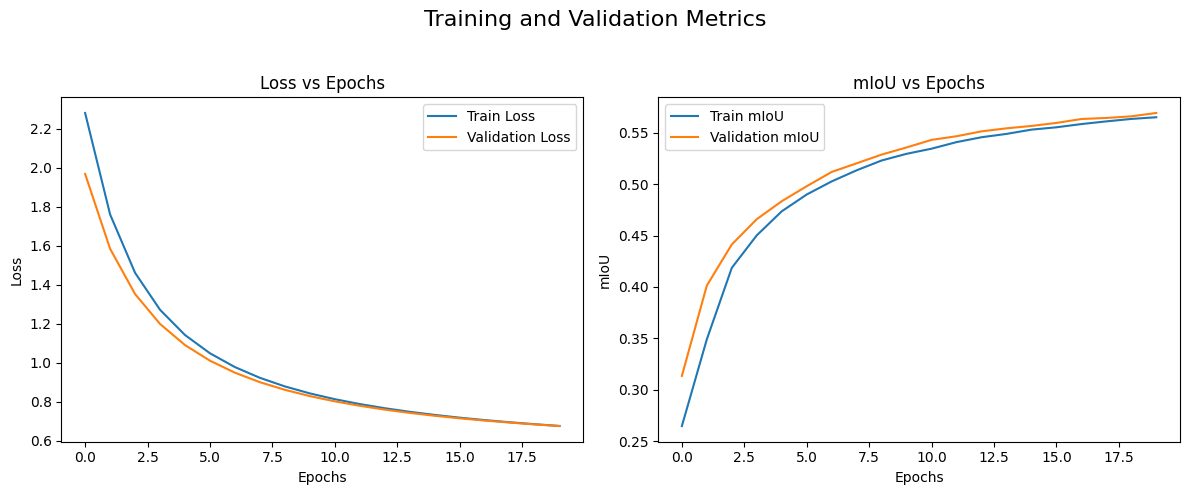

Test mIoU: 0.5664


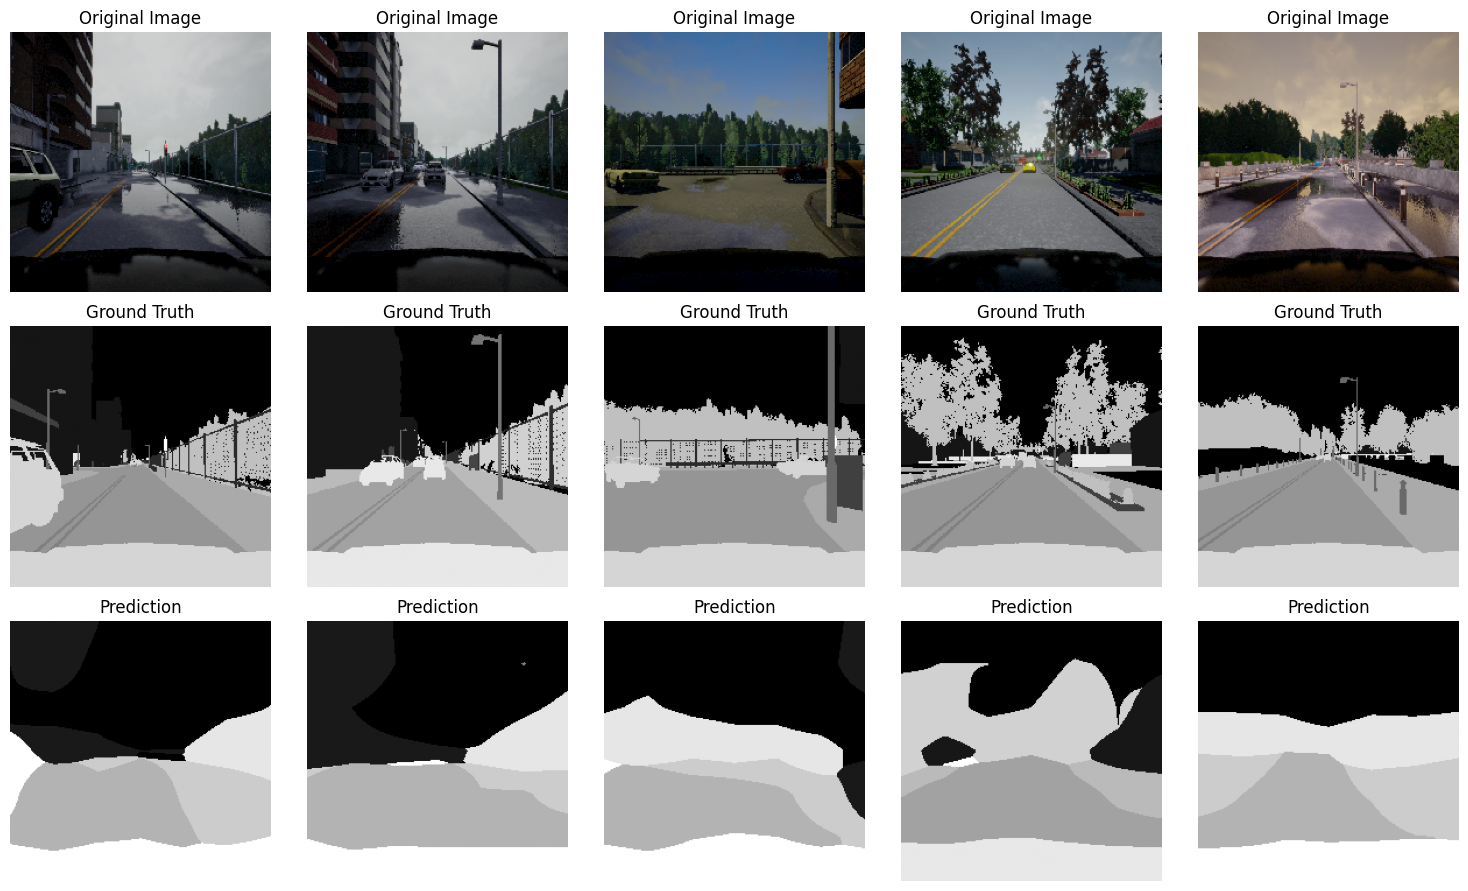

In [17]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
test(model, test_loader)
visualize_model_results(model, test_loader)

## FCN-16s (Frozen weights)

In [18]:
model = FCN(13, 16, True)
train_losses, train_mious, val_losses, val_mious = train(model, train_loader, val_loader, 20)
torch.save(model.state_dict(), "fcn_16s_freezed.pth")

Epoch 1/20


Train Loss: 2.0368, Train mIoU: 0.2697, Val Loss: 1.3398, Val mIoU: 0.3961
Epoch 2/20


Train Loss: 1.0852, Train mIoU: 0.4747, Val Loss: 0.8956, Val mIoU: 0.5417
Epoch 3/20


Train Loss: 0.8054, Train mIoU: 0.5682, Val Loss: 0.7269, Val mIoU: 0.5985
Epoch 4/20


Train Loss: 0.6807, Train mIoU: 0.6107, Val Loss: 0.6386, Val mIoU: 0.6286
Epoch 5/20


Train Loss: 0.6092, Train mIoU: 0.6348, Val Loss: 0.5833, Val mIoU: 0.6457
Epoch 6/20


Train Loss: 0.5623, Train mIoU: 0.6492, Val Loss: 0.5452, Val mIoU: 0.6588
Epoch 7/20


Train Loss: 0.5287, Train mIoU: 0.6598, Val Loss: 0.5168, Val mIoU: 0.6658
Epoch 8/20


Train Loss: 0.5035, Train mIoU: 0.6670, Val Loss: 0.4951, Val mIoU: 0.6738
Epoch 9/20


Train Loss: 0.4837, Train mIoU: 0.6731, Val Loss: 0.4775, Val mIoU: 0.6796
Epoch 10/20


Train Loss: 0.4677, Train mIoU: 0.6777, Val Loss: 0.4632, Val mIoU: 0.6835
Epoch 11/20


Train Loss: 0.4544, Train mIoU: 0.6819, Val Loss: 0.4513, Val mIoU: 0.6874
Epoch 12/20


Train Loss: 0.4431, Train mIoU: 0.6853, Val Loss: 0.4413, Val mIoU: 0.6899
Epoch 13/20


Train Loss: 0.4334, Train mIoU: 0.6883, Val Loss: 0.4323, Val mIoU: 0.6927
Epoch 14/20


Train Loss: 0.4250, Train mIoU: 0.6908, Val Loss: 0.4244, Val mIoU: 0.6950
Epoch 15/20


Train Loss: 0.4176, Train mIoU: 0.6930, Val Loss: 0.4176, Val mIoU: 0.6981
Epoch 16/20


Train Loss: 0.4110, Train mIoU: 0.6951, Val Loss: 0.4117, Val mIoU: 0.6993
Epoch 17/20


Train Loss: 0.4051, Train mIoU: 0.6968, Val Loss: 0.4061, Val mIoU: 0.7015
Epoch 18/20


Train Loss: 0.3997, Train mIoU: 0.6987, Val Loss: 0.4014, Val mIoU: 0.7022
Epoch 19/20


Train Loss: 0.3949, Train mIoU: 0.7001, Val Loss: 0.3968, Val mIoU: 0.7036
Epoch 20/20


Train Loss: 0.3905, Train mIoU: 0.7015, Val Loss: 0.3926, Val mIoU: 0.7052


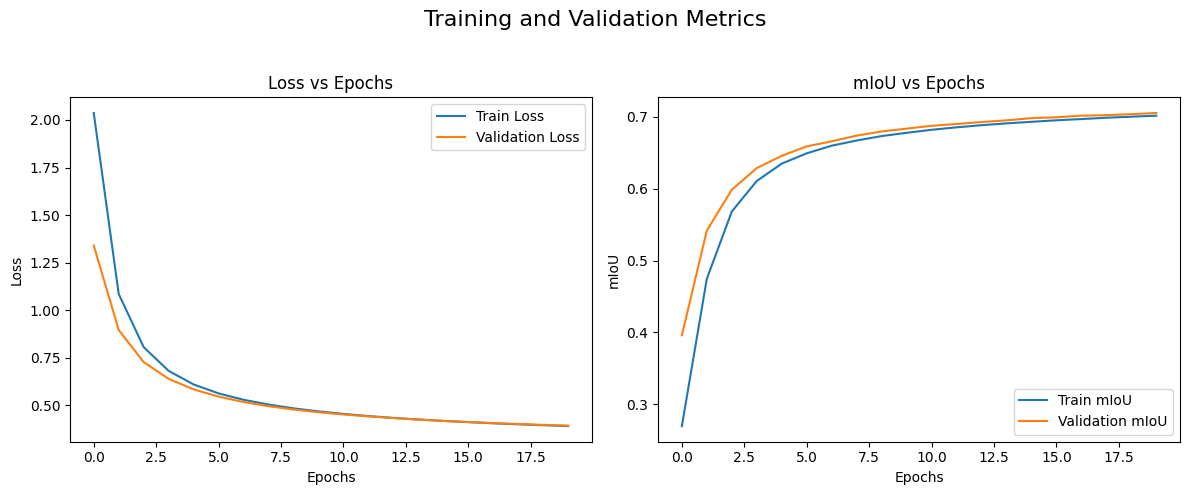

Test mIoU: 0.7020


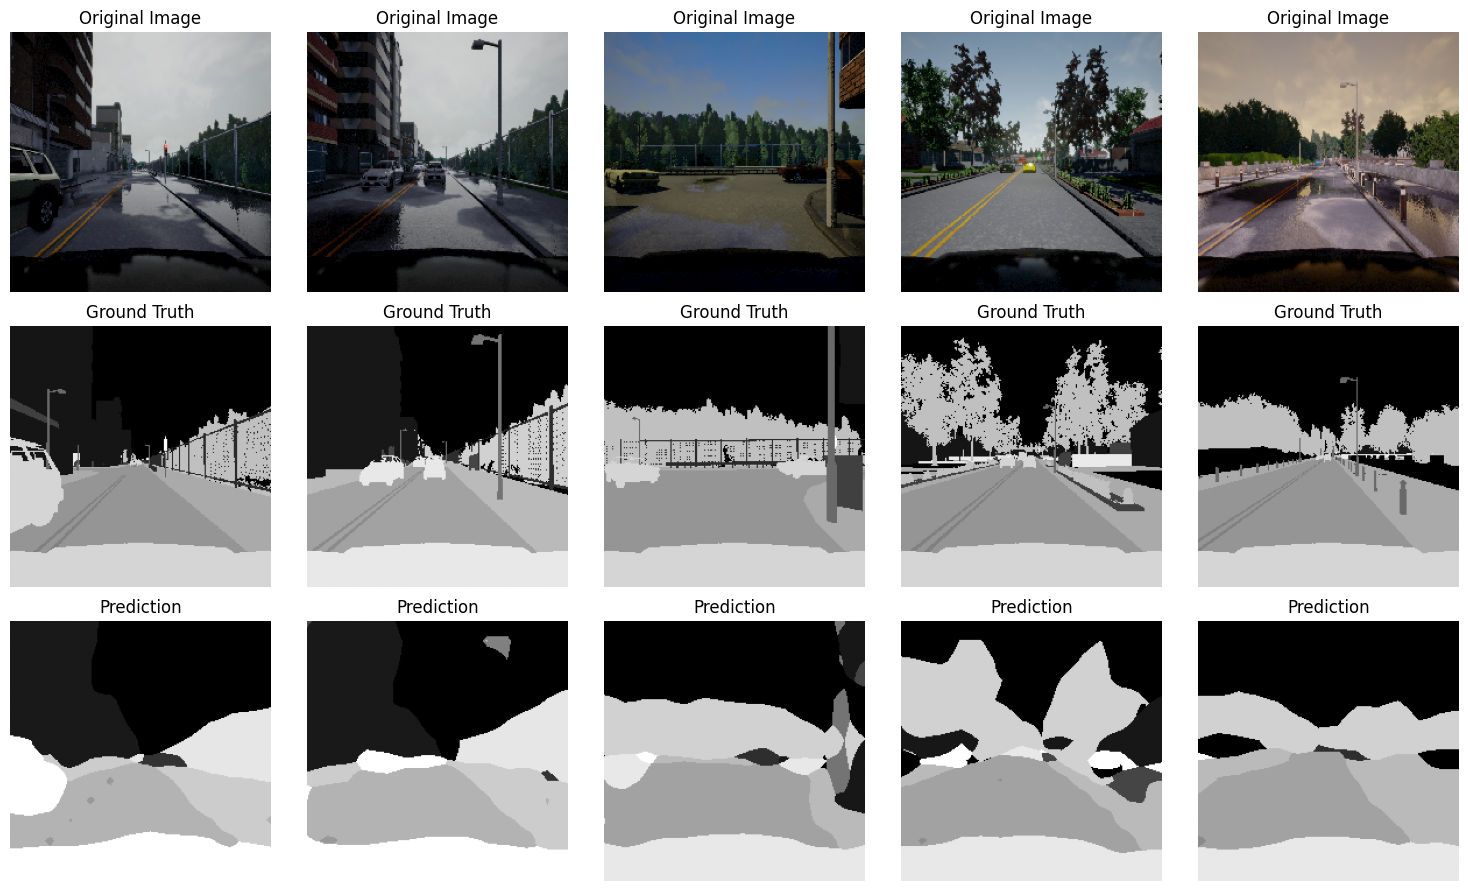

In [19]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
test(model, test_loader)
visualize_model_results(model, test_loader)

## FCN-8s (Frozen weights)

In [20]:
model = FCN(13, 8, True)
train_losses, train_mious, val_losses, val_mious = train(model, train_loader, val_loader, 20)
torch.save(model.state_dict(), "fcn_8s_freezed.pth")

Epoch 1/20


Train Loss: 2.7873, Train mIoU: 0.2672, Val Loss: 1.6383, Val mIoU: 0.3971
Epoch 2/20


Train Loss: 1.2360, Train mIoU: 0.4867, Val Loss: 0.9821, Val mIoU: 0.5602
Epoch 3/20


Train Loss: 0.8651, Train mIoU: 0.5901, Val Loss: 0.7760, Val mIoU: 0.6231
Epoch 4/20


Train Loss: 0.7181, Train mIoU: 0.6320, Val Loss: 0.6713, Val mIoU: 0.6503
Epoch 5/20


Train Loss: 0.6328, Train mIoU: 0.6551, Val Loss: 0.6032, Val mIoU: 0.6690
Epoch 6/20


Train Loss: 0.5742, Train mIoU: 0.6701, Val Loss: 0.5534, Val mIoU: 0.6830
Epoch 7/20


Train Loss: 0.5311, Train mIoU: 0.6814, Val Loss: 0.5163, Val mIoU: 0.6922
Epoch 8/20


Train Loss: 0.4973, Train mIoU: 0.6901, Val Loss: 0.4864, Val mIoU: 0.7001
Epoch 9/20


Train Loss: 0.4703, Train mIoU: 0.6973, Val Loss: 0.4619, Val mIoU: 0.7072
Epoch 10/20


Train Loss: 0.4479, Train mIoU: 0.7032, Val Loss: 0.4419, Val mIoU: 0.7125
Epoch 11/20


Train Loss: 0.4290, Train mIoU: 0.7086, Val Loss: 0.4246, Val mIoU: 0.7151
Epoch 12/20


Train Loss: 0.4129, Train mIoU: 0.7127, Val Loss: 0.4099, Val mIoU: 0.7210
Epoch 13/20


Train Loss: 0.3990, Train mIoU: 0.7171, Val Loss: 0.3965, Val mIoU: 0.7246
Epoch 14/20


Train Loss: 0.3867, Train mIoU: 0.7208, Val Loss: 0.3854, Val mIoU: 0.7271
Epoch 15/20


Train Loss: 0.3760, Train mIoU: 0.7240, Val Loss: 0.3753, Val mIoU: 0.7309
Epoch 16/20


Train Loss: 0.3664, Train mIoU: 0.7270, Val Loss: 0.3663, Val mIoU: 0.7330
Epoch 17/20


Train Loss: 0.3578, Train mIoU: 0.7296, Val Loss: 0.3584, Val mIoU: 0.7354
Epoch 18/20


Train Loss: 0.3500, Train mIoU: 0.7322, Val Loss: 0.3513, Val mIoU: 0.7377
Epoch 19/20


Train Loss: 0.3430, Train mIoU: 0.7346, Val Loss: 0.3445, Val mIoU: 0.7398
Epoch 20/20


Train Loss: 0.3367, Train mIoU: 0.7364, Val Loss: 0.3390, Val mIoU: 0.7409


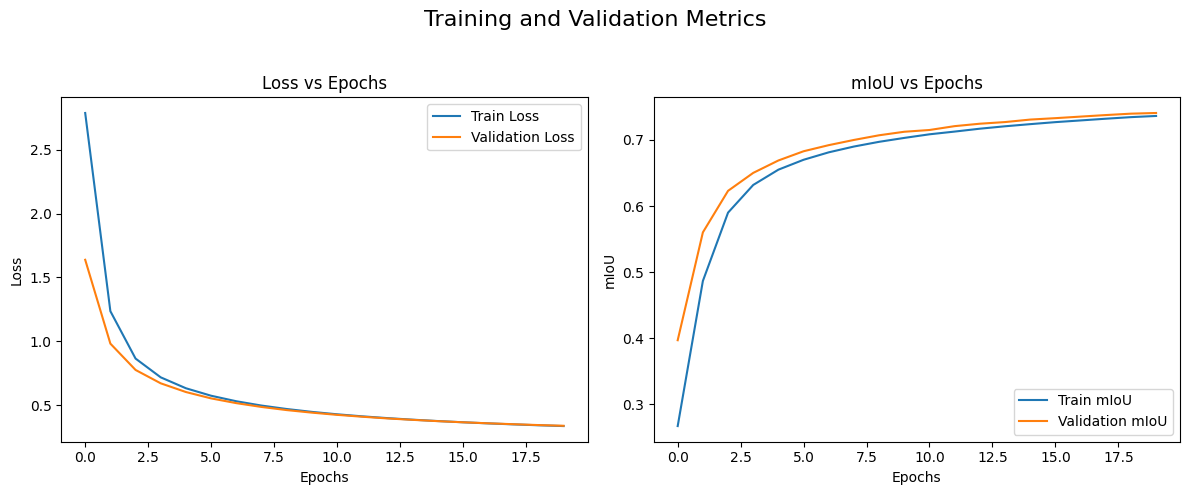

Test mIoU: 0.7372


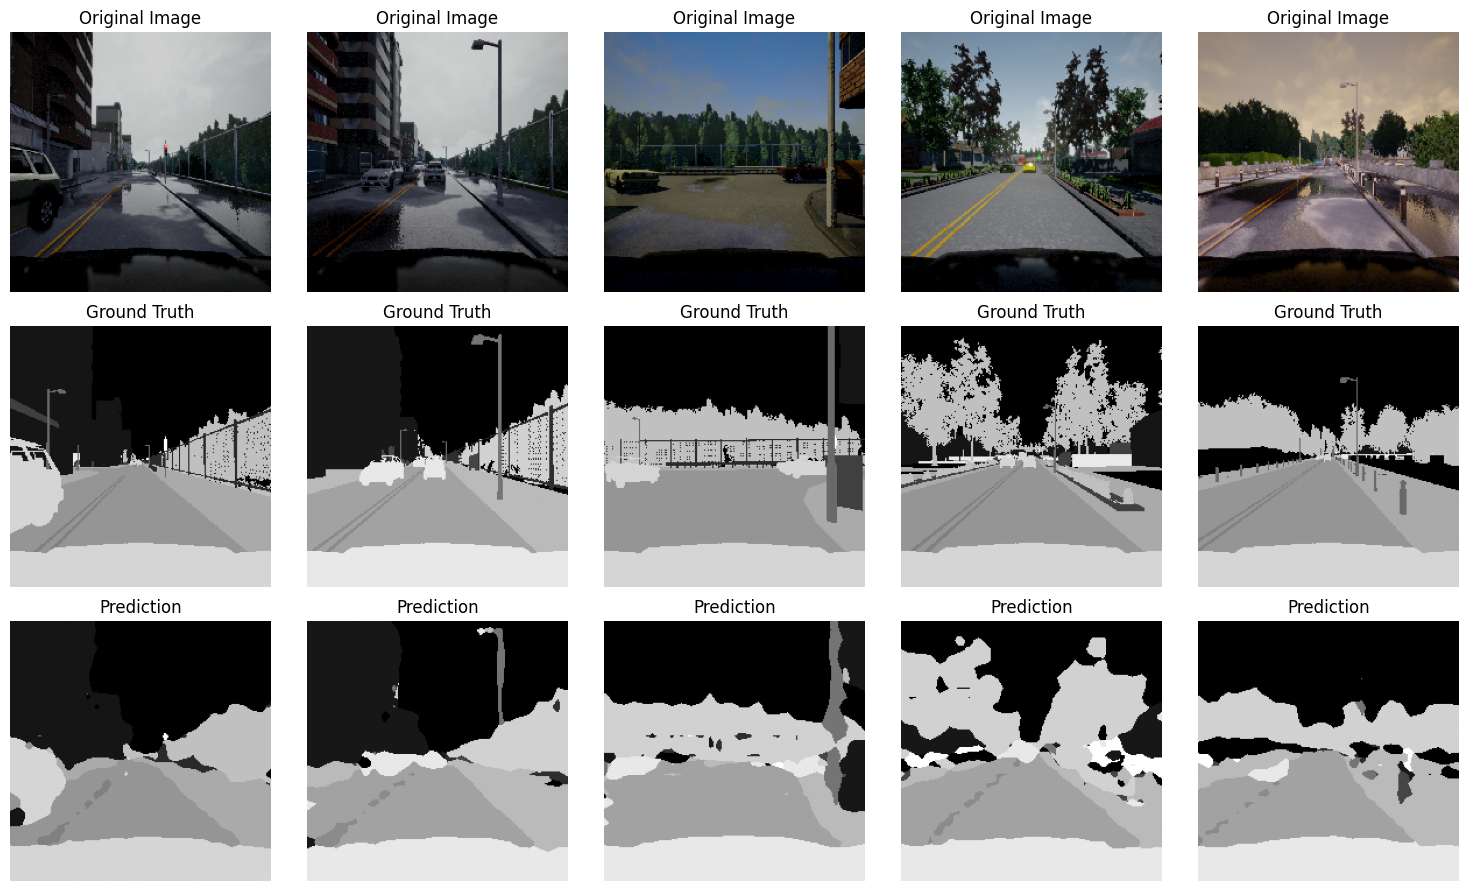

In [21]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
test(model, test_loader)
visualize_model_results(model, test_loader)

## FCN-32s (Fine Tuned)

In [22]:
model = FCN(13, 32, False)
train_losses, train_mious, val_losses, val_mious = train(model, train_loader, val_loader, 20)
torch.save(model.state_dict(), "fcn_32s_unfreezed.pth")

Epoch 1/20


Train Loss: 0.6050, Train mIoU: 0.6207, Val Loss: 0.3778, Val mIoU: 0.6839
Epoch 2/20


Train Loss: 0.3457, Train mIoU: 0.7013, Val Loss: 0.3301, Val mIoU: 0.7109
Epoch 3/20


Train Loss: 0.3130, Train mIoU: 0.7151, Val Loss: 0.3103, Val mIoU: 0.7227
Epoch 4/20


Train Loss: 0.2956, Train mIoU: 0.7237, Val Loss: 0.2986, Val mIoU: 0.7240
Epoch 5/20


Train Loss: 0.2846, Train mIoU: 0.7280, Val Loss: 0.2900, Val mIoU: 0.7256
Epoch 6/20


Train Loss: 0.2758, Train mIoU: 0.7323, Val Loss: 0.2825, Val mIoU: 0.7320
Epoch 7/20


Train Loss: 0.2709, Train mIoU: 0.7339, Val Loss: 0.2816, Val mIoU: 0.7324
Epoch 8/20


Train Loss: 0.2667, Train mIoU: 0.7347, Val Loss: 0.2767, Val mIoU: 0.7386
Epoch 9/20


Train Loss: 0.2602, Train mIoU: 0.7389, Val Loss: 0.2707, Val mIoU: 0.7415
Epoch 10/20


Train Loss: 0.2573, Train mIoU: 0.7402, Val Loss: 0.2689, Val mIoU: 0.7408
Epoch 11/20


Train Loss: 0.2540, Train mIoU: 0.7419, Val Loss: 0.2655, Val mIoU: 0.7349
Epoch 12/20


Train Loss: 0.2521, Train mIoU: 0.7420, Val Loss: 0.2638, Val mIoU: 0.7421
Epoch 13/20


Train Loss: 0.2513, Train mIoU: 0.7431, Val Loss: 0.2618, Val mIoU: 0.7420
Epoch 14/20


Train Loss: 0.2485, Train mIoU: 0.7438, Val Loss: 0.2611, Val mIoU: 0.7395
Epoch 15/20


Train Loss: 0.2468, Train mIoU: 0.7451, Val Loss: 0.2556, Val mIoU: 0.7436
Epoch 16/20


Train Loss: 0.2431, Train mIoU: 0.7467, Val Loss: 0.2544, Val mIoU: 0.7463
Epoch 17/20


Train Loss: 0.2419, Train mIoU: 0.7476, Val Loss: 0.2566, Val mIoU: 0.7458
Epoch 18/20


Train Loss: 0.2415, Train mIoU: 0.7474, Val Loss: 0.2557, Val mIoU: 0.7436
Epoch 19/20


Train Loss: 0.2395, Train mIoU: 0.7489, Val Loss: 0.2509, Val mIoU: 0.7454
Epoch 20/20


Train Loss: 0.2382, Train mIoU: 0.7491, Val Loss: 0.2509, Val mIoU: 0.7443


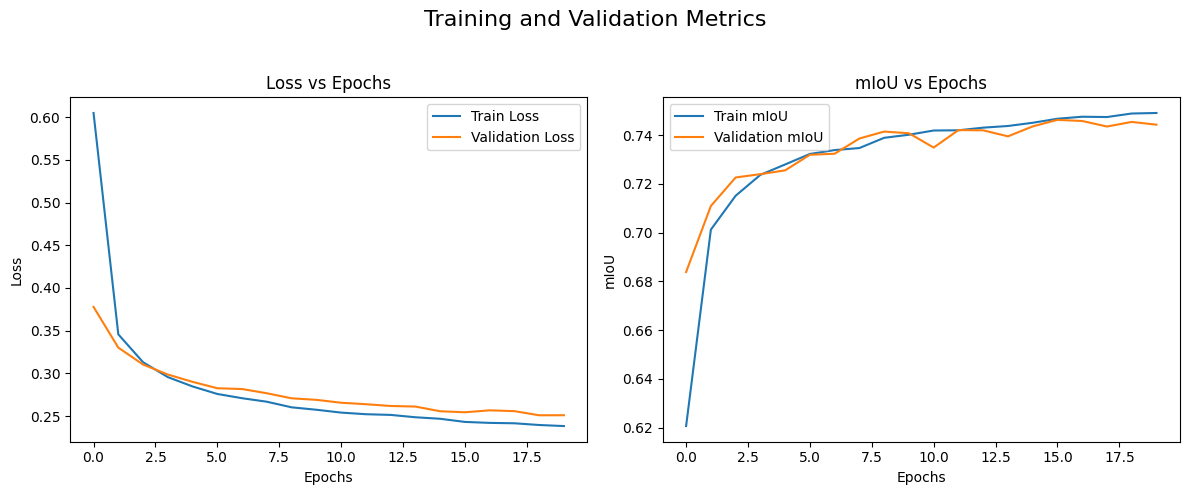

Test mIoU: 0.7413


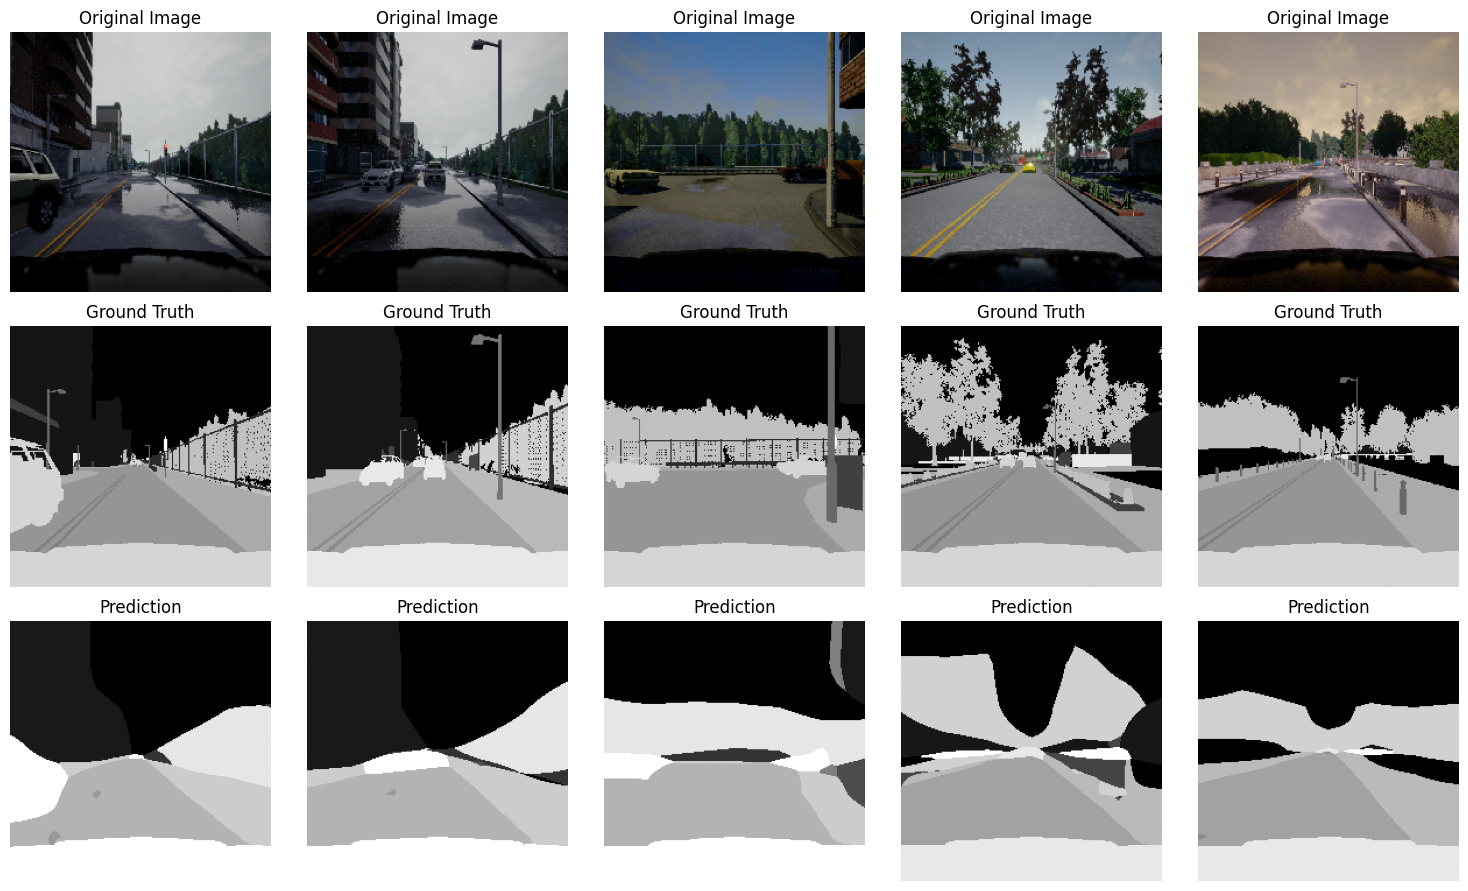

In [23]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
test(model, test_loader)
visualize_model_results(model, test_loader)

## FCN-16s (Fine Tuned)

In [24]:
model = FCN(13, 16, False)
train_losses, train_mious, val_losses, val_mious = train(model, train_loader, val_loader, 20)
torch.save(model.state_dict(), "fcn_16s_unfreezed.pth")

Epoch 1/20


Train Loss: 0.4983, Train mIoU: 0.6794, Val Loss: 0.2996, Val mIoU: 0.7414
Epoch 2/20


Train Loss: 0.2711, Train mIoU: 0.7479, Val Loss: 0.2563, Val mIoU: 0.7589
Epoch 3/20


Train Loss: 0.2404, Train mIoU: 0.7606, Val Loss: 0.2359, Val mIoU: 0.7653
Epoch 4/20


Train Loss: 0.2234, Train mIoU: 0.7678, Val Loss: 0.2256, Val mIoU: 0.7723
Epoch 5/20


Train Loss: 0.2133, Train mIoU: 0.7725, Val Loss: 0.2187, Val mIoU: 0.7748
Epoch 6/20


Train Loss: 0.2053, Train mIoU: 0.7762, Val Loss: 0.2118, Val mIoU: 0.7751
Epoch 7/20


Train Loss: 0.2002, Train mIoU: 0.7787, Val Loss: 0.2091, Val mIoU: 0.7778
Epoch 8/20


Train Loss: 0.1952, Train mIoU: 0.7816, Val Loss: 0.2057, Val mIoU: 0.7805
Epoch 9/20


Train Loss: 0.1908, Train mIoU: 0.7833, Val Loss: 0.2032, Val mIoU: 0.7797
Epoch 10/20


Train Loss: 0.1886, Train mIoU: 0.7844, Val Loss: 0.2026, Val mIoU: 0.7803
Epoch 11/20


Train Loss: 0.1870, Train mIoU: 0.7850, Val Loss: 0.2000, Val mIoU: 0.7832
Epoch 12/20


Train Loss: 0.1845, Train mIoU: 0.7866, Val Loss: 0.1984, Val mIoU: 0.7821
Epoch 13/20


Train Loss: 0.1814, Train mIoU: 0.7881, Val Loss: 0.1952, Val mIoU: 0.7845
Epoch 14/20


Train Loss: 0.1786, Train mIoU: 0.7898, Val Loss: 0.1951, Val mIoU: 0.7844
Epoch 15/20


Train Loss: 0.1783, Train mIoU: 0.7892, Val Loss: 0.1953, Val mIoU: 0.7878
Epoch 16/20


Train Loss: 0.1766, Train mIoU: 0.7908, Val Loss: 0.1934, Val mIoU: 0.7880
Epoch 17/20


Train Loss: 0.1759, Train mIoU: 0.7908, Val Loss: 0.1919, Val mIoU: 0.7865
Epoch 18/20


Train Loss: 0.1740, Train mIoU: 0.7919, Val Loss: 0.1913, Val mIoU: 0.7853
Epoch 19/20


Train Loss: 0.1730, Train mIoU: 0.7926, Val Loss: 0.1917, Val mIoU: 0.7878
Epoch 20/20


Train Loss: 0.1718, Train mIoU: 0.7933, Val Loss: 0.1905, Val mIoU: 0.7863


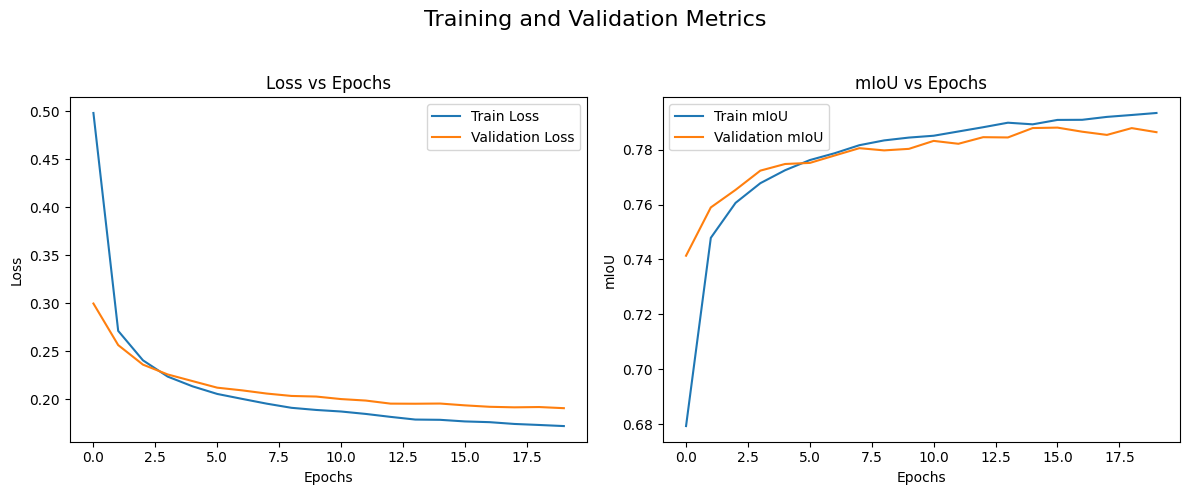

Test mIoU: 0.7806


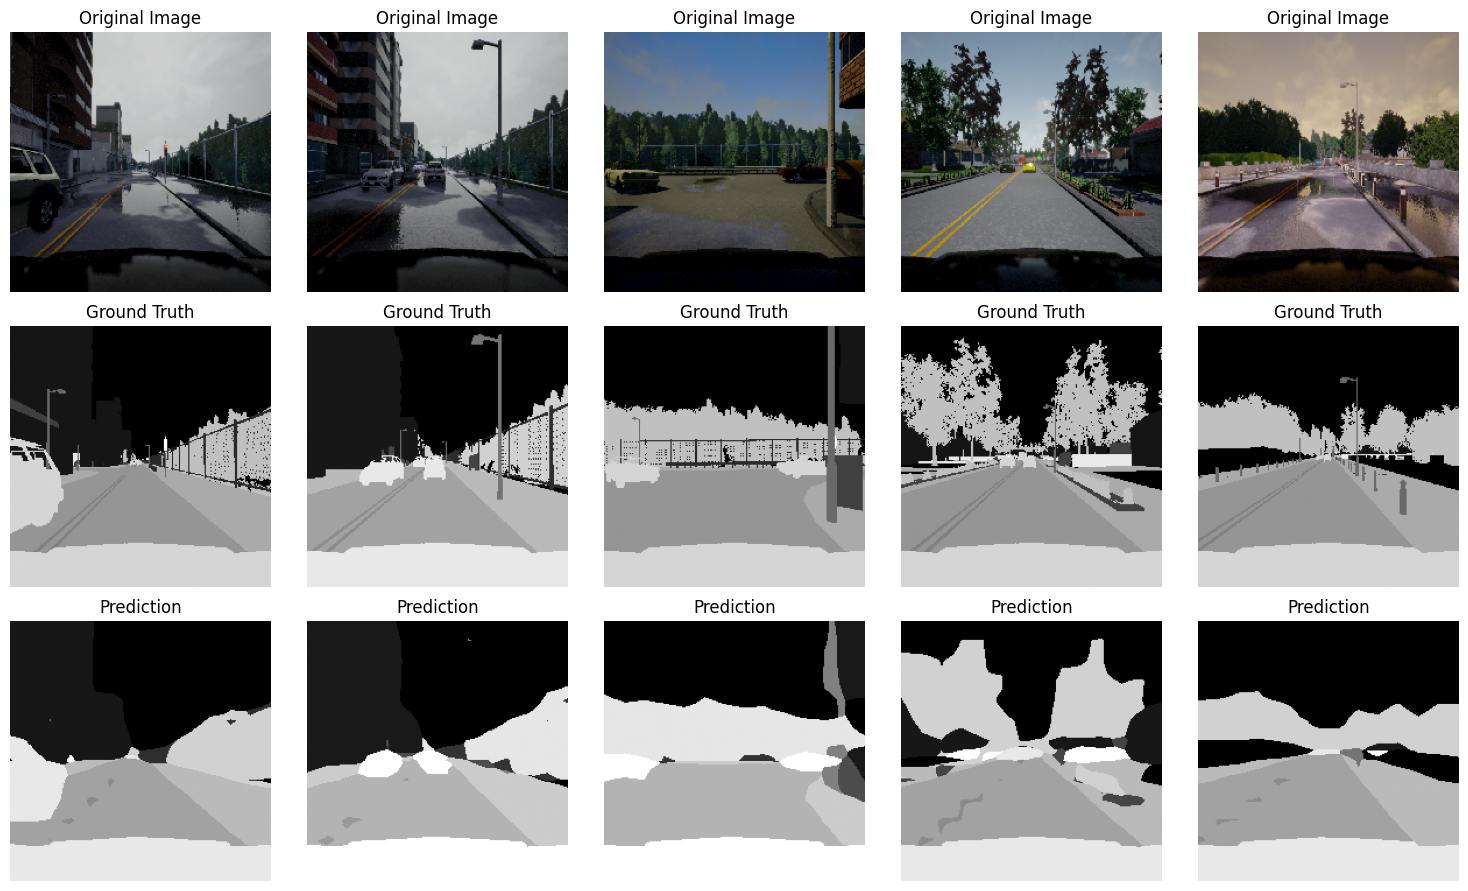

In [25]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
test(model, test_loader)
visualize_model_results(model, test_loader)

## FCN-8s (Fine Tuned)

In [26]:
model = FCN(13, 8, False)
train_losses, train_mious, val_losses, val_mious = train(model, train_loader, val_loader, 20)
torch.save(model.state_dict(), "fcn_8s_unfreezed.pth")

Epoch 1/20


Train Loss: 0.5560, Train mIoU: 0.6903, Val Loss: 0.2936, Val mIoU: 0.7579
Epoch 2/20


Train Loss: 0.2655, Train mIoU: 0.7602, Val Loss: 0.2459, Val mIoU: 0.7758
Epoch 3/20


Train Loss: 0.2312, Train mIoU: 0.7740, Val Loss: 0.2239, Val mIoU: 0.7831
Epoch 4/20


Train Loss: 0.2129, Train mIoU: 0.7814, Val Loss: 0.2100, Val mIoU: 0.7882
Epoch 5/20


Train Loss: 0.1998, Train mIoU: 0.7876, Val Loss: 0.2025, Val mIoU: 0.7900
Epoch 6/20


Train Loss: 0.1911, Train mIoU: 0.7918, Val Loss: 0.1944, Val mIoU: 0.7932
Epoch 7/20


Train Loss: 0.1841, Train mIoU: 0.7951, Val Loss: 0.1902, Val mIoU: 0.7976
Epoch 8/20


Train Loss: 0.1793, Train mIoU: 0.7973, Val Loss: 0.1852, Val mIoU: 0.8006
Epoch 9/20


Train Loss: 0.1737, Train mIoU: 0.8004, Val Loss: 0.1810, Val mIoU: 0.8035
Epoch 10/20


Train Loss: 0.1700, Train mIoU: 0.8023, Val Loss: 0.1779, Val mIoU: 0.8056
Epoch 11/20


Train Loss: 0.1663, Train mIoU: 0.8044, Val Loss: 0.1755, Val mIoU: 0.8064
Epoch 12/20


Train Loss: 0.1634, Train mIoU: 0.8056, Val Loss: 0.1747, Val mIoU: 0.8087
Epoch 13/20


Train Loss: 0.1620, Train mIoU: 0.8062, Val Loss: 0.1711, Val mIoU: 0.8090
Epoch 14/20


Train Loss: 0.1589, Train mIoU: 0.8081, Val Loss: 0.1703, Val mIoU: 0.8090
Epoch 15/20


Train Loss: 0.1569, Train mIoU: 0.8093, Val Loss: 0.1681, Val mIoU: 0.8096
Epoch 16/20


Train Loss: 0.1544, Train mIoU: 0.8107, Val Loss: 0.1656, Val mIoU: 0.8114
Epoch 17/20


Train Loss: 0.1528, Train mIoU: 0.8116, Val Loss: 0.1654, Val mIoU: 0.8114
Epoch 18/20


Train Loss: 0.1516, Train mIoU: 0.8121, Val Loss: 0.1662, Val mIoU: 0.8055
Epoch 19/20


Train Loss: 0.1512, Train mIoU: 0.8125, Val Loss: 0.1630, Val mIoU: 0.8123
Epoch 20/20


Train Loss: 0.1487, Train mIoU: 0.8139, Val Loss: 0.1612, Val mIoU: 0.8134


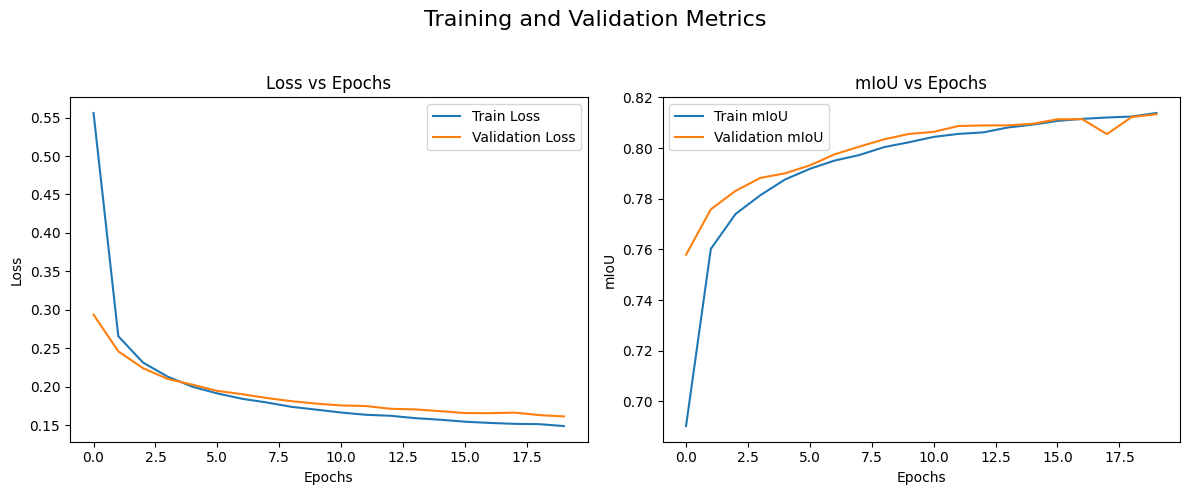

Test mIoU: 0.8063


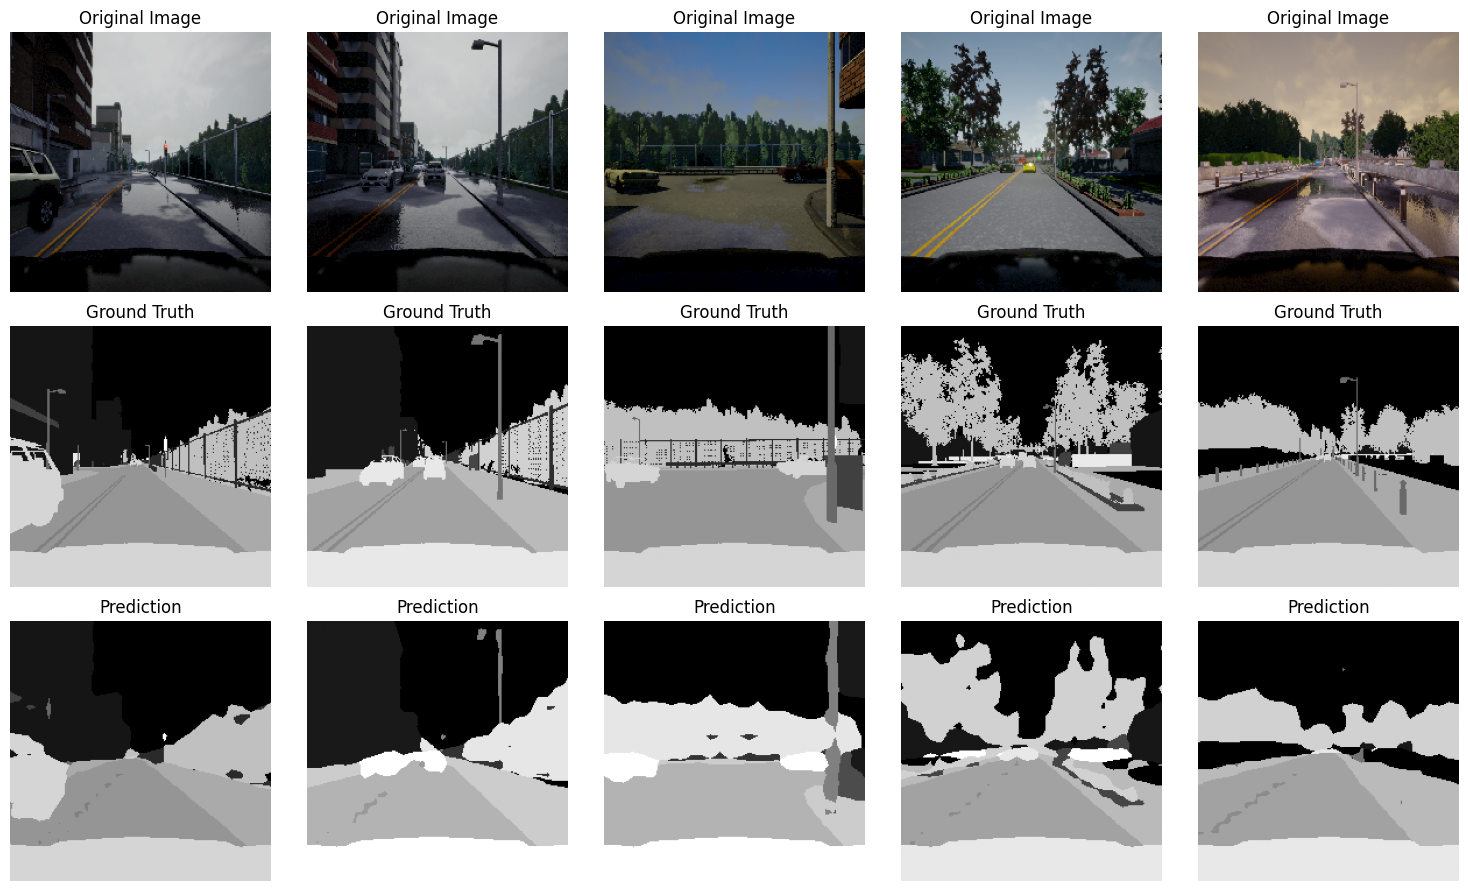

In [27]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
test(model, test_loader)
visualize_model_results(model, test_loader)

## Test Results

| Model     | Freezed         | Unfreezed       |
|-----------|-----------------|-----------------|
| FCN-32s   | 0.5664          | 0.7413          |
| FCN-16s   | 0.7020          | 0.7806          |
| FCN-8s    | 0.7372          | 0.8063          |

### Difference between the variants
- The three different variants of the FCN model make use of different levels of features extracted from the image
- FCN-32s uses only the final features extracted (pool5) via the backbone (VGG19)
- FCN-16s uses pool5 (and upsampling to match dims) and pool4 together
- FCN-8s uses the features used in 16s after upsampling them and pool3 (thus having most fine grain information about the input)
- Thus, as can be expected, there is an increase in mIOU going from 32s to 8s
- Visually you can see a clear improvement in the structure of the predicted segments

### Difference between frozen and fine tuned backbone
- There is a huge improvement in the mIOU when the backbone is unfreezed
- For FCN-32s there is an increase of ~0.18
- For FCN-16s and FCN-8s there is an increase of 0.07-0.08